In [765]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import pandas as pd

In [766]:
df = pd.read_csv('train.csv')
df['label'] = df['label'].map({'correct': 1, 'incorrect': 0})
df = df.dropna()

df_train_dist = pd.read_csv('train_dist.csv')
df_test_dist = pd.read_csv('test_dist.csv')

In [767]:
df_test_dist

,tripid,distance
0,213284604,8.283
1,213286352,56.384
2,213293973,7.760
3,213294622,5.015
4,213298687,3.046
...,...,...
8571,222856243,5.853
8572,222857785,10.815
8573,222858416,2.300
8574,222858691,6.213


In [768]:
df.shape

(16968, 14)

In [769]:
df.isnull().sum()

tripid                       0
additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
pickup_time                  0
drop_time                    0
pick_lat                     0
pick_lon                     0
drop_lat                     0
drop_lon                     0
fare                         0
label                        0
dtype: int64

In [770]:
df['pick_up_h'] = [int(d.split(' ')[1].split(':')[0]) for d in df['pickup_time']]
df['drop_h'] = [int(d.split(' ')[1].split(':')[0]) for d in df['drop_time']]

#df['day'] = [d.split(' ')[0] for d in df['pickup_time']]
#df['month'] = [int(d.split('/')[0]) for d in df['day']]
#df['day'] = [int(d.split('/')[1]) for d in df['day']]
#df['day_of_week'] = [d.split(' ')[0] for d in df['pickup_time']]
#df['day_of_week'] = pd.to_datetime(df['day_of_week'])
#df['day_of_week'] = df['day_of_week'].dt.weekday_name
#df['day_of_week'].value_counts()
#df['day_of_week'] = df['day_of_week'].map({'Monday': 1, 'Tuesday': 1,'Wednesday': 1, 'Thursday': 1,'Friday': 1, 'Saturday': 2,'Sunday': 2})
#df['month'] = df['month'].map({11: 1, 12: 2 , 1: 3})

In [771]:
df = df.drop(['pickup_time','drop_time'], axis = 1)

In [772]:
df

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pick_up_h,drop_h
0,189123628,10.5,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,1,0,0
1,189125358,10.5,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,1,0,1
2,189125719,10.5,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,1,1,1
3,189127273,10.5,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,1,2,2
5,189129552,10.5,3407.0,182.0,0.0000,112.0,7.13402,79.8969,6.91865,79.8649,1065.02,1,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17171,213803193,10.5,838.0,93.0,5.4219,451.0,7.29073,80.6367,7.28891,80.6557,198.26,1,22,22
17172,213812756,10.5,2151.0,428.0,0.0000,39.0,6.90569,79.8516,6.95089,79.9389,581.23,1,23,23
17173,213813930,10.5,263.0,9.0,0.0000,110.0,7.09210,79.9000,7.10135,79.9017,76.20,1,23,23
17174,213815405,10.5,858.0,115.0,0.0000,317.0,6.94540,79.8768,6.93574,79.9010,133.31,1,23,23


In [773]:
df['delta_lon'] = df['pick_lon'] - df['drop_lon']
df['delta_lat'] = df['pick_lat'] - df['drop_lat']

In [774]:
import math
import numpy as np
def deg_to_rad(dr):
    return (dr*math.pi)/180

df['pick_lat'] = deg_to_rad(df['pick_lat'])
df['pick_lon'] = deg_to_rad(df['pick_lon'])
df['drop_lat'] = deg_to_rad(df['drop_lat'])
df['drop_lon'] = deg_to_rad(df['drop_lon'])
dlon = df['drop_lon'] - df['pick_lon']
dlat = df['drop_lat'] - df['pick_lat']
df['dist'] = np.sin(dlat/2)**2 + np.cos(df['pick_lat'])*np.cos(df['drop_lat'])*np.sin(dlon/2)**2
df['dist'] = 2*np.arctan2(df['dist']**0.5,(1-df['dist'])**0.5)
R = 6373.0
df['dist'] = R*df['dist']
df['dist'] = ((df['pick_lat']-df['drop_lat'])**2 + (df['pick_lon']-df['drop_lon'])**2)**0.5
df['fare_min'] = (df['fare'] / abs(df['duration'] +1 - df['meter_waiting']))*60

In [775]:
df['dist'] = df_train_dist['distance']
df['fare_dist'] = (df['fare'] / abs(df['dist']))

In [776]:
df

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pick_up_h,drop_h,delta_lon,delta_lat,dist,fare_min,fare_dist
0,189123628,10.5,834.0,56.0,0.0000,64.0,0.119774,1.394506,0.120485,1.394139,270.32,1,0,0,0.0210,-0.04078,7.801,20.820539,34.651968
1,189125358,10.5,791.0,47.0,0.0000,134.0,0.120181,1.394490,0.120667,1.394384,197.85,1,0,1,0.0061,-0.02784,5.211,15.934228,37.967761
2,189125719,10.5,1087.0,80.0,0.0000,61.0,0.120574,1.393909,0.121068,1.394773,301.64,1,1,1,-0.0495,-0.02830,9.637,17.954762,31.300197
3,189127273,10.5,598.0,271.0,15.6638,68.0,0.120876,1.394335,0.120907,1.394467,82.30,1,2,2,-0.0076,-0.00178,1.880,15.054878,43.776596
5,189129552,10.5,3407.0,182.0,0.0000,112.0,0.124512,1.394464,0.120753,1.393905,1065.02,1,5,6,0.0320,0.21537,31.163,19.808184,34.175785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17171,213803193,10.5,838.0,93.0,5.4219,451.0,0.127247,1.407376,0.127215,1.407708,198.26,1,22,22,-0.0190,0.00182,3.943,15.945845,50.281512
17172,213812756,10.5,2151.0,428.0,0.0000,39.0,0.120527,1.393673,0.121316,1.395197,581.23,1,23,23,-0.0873,-0.04520,17.569,20.228422,33.082702
17173,213813930,10.5,263.0,9.0,0.0000,110.0,0.123780,1.394518,0.123942,1.394548,76.20,1,23,23,-0.0017,-0.00925,2.697,17.929412,28.253615
17174,213815405,10.5,858.0,115.0,0.0000,317.0,0.121220,1.394113,0.121051,1.394536,133.31,1,23,23,-0.0242,0.00966,3.398,10.750806,39.231901


In [777]:
def calculate_direction(d_lon, d_lat):
    result = np.zeros(len(d_lon))
    l = np.sqrt(d_lon**2 + d_lat**2)
    result[d_lon>0] = (180/np.pi)*np.arcsin(d_lat[d_lon>0]/l[d_lon>0])
    idx = (d_lon<0) & (d_lat>0)
    result[idx] = 180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    idx = (d_lon<0) & (d_lat<0)
    result[idx] = -180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    return result

In [779]:
df['direction'] = calculate_direction(df.delta_lon, df.delta_lat)

In [780]:
df = df.drop(['tripid','delta_lon','delta_lat'], axis = 1)

In [781]:
y = df['label']
X = df.drop(['label'],axis=1)

In [782]:
X['fare'].value_counts()

60.50     455
60.00      55
60.58      18
0.00       14
61.16      13
         ... 
93.29       1
178.13      1
912.68      1
306.70      1
413.79      1
Name: fare, Length: 13752, dtype: int64

In [783]:
L = ['pick_up_h','day','month','day_of_week']

def dummy_df(df, todummy_list):
    
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix = x, dummy_na=False)
        df = df.drop(x,1)
        df = pd.concat((df, dummies), axis=1)
        
    return df

In [784]:
X.head(100)

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pick_up_h,drop_h,dist,fare_min,fare_dist,direction
0,10.5,834.0,56.0,0.0000,64.0,0.119774,1.394506,0.120485,1.394139,270.32,0,0,7.801,20.820539,34.651968,-62.753420
1,10.5,791.0,47.0,0.0000,134.0,0.120181,1.394490,0.120667,1.394384,197.85,0,1,5.211,15.934228,37.967761,-77.641274
2,10.5,1087.0,80.0,0.0000,61.0,0.120574,1.393909,0.121068,1.394773,301.64,1,1,9.637,17.954762,31.300197,-150.242655
3,10.5,598.0,271.0,15.6638,68.0,0.120876,1.394335,0.120907,1.394467,82.30,2,2,1.880,15.054878,43.776596,-166.818323
5,10.5,3407.0,182.0,0.0000,112.0,0.124512,1.394464,0.120753,1.393905,1065.02,5,6,31.163,19.808184,34.175785,81.548736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,10.5,2443.0,370.0,21.3860,200.0,0.120906,1.393960,0.121879,1.395066,399.96,15,16,11.092,11.570685,36.058420,-138.663430
101,10.5,1193.0,311.0,17.9758,30.0,0.120203,1.394232,0.120316,1.394677,193.61,15,16,5.076,13.155832,38.142238,-165.720823
102,10.5,1582.0,376.0,21.9208,5.0,0.119898,1.394181,0.119895,1.394178,276.01,16,16,0.022,13.720464,12545.909091,40.364537
103,5.0,382.0,28.0,1.6324,0.0,0.118402,1.394293,0.118482,1.394488,87.27,16,16,1.864,14.749859,46.818670,-157.671344


In [786]:
from xgboost import XGBClassifier
# get a stacking ensemble of models
from sklearn.ensemble import VotingClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.datasets import load_iris 
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
  
# loading iris dataset 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state=0)   

In [787]:
#cat_features = ['pick_up_h','day','month','day_of_week']

In [788]:
cat = CatBoostClassifier(iterations=None,learning_rate=0.0204,depth=None,)
cat.fit(X, y) 
y_pred = cat.predict(X_test)

0:	learn: 0.6624167	total: 9.33ms	remaining: 9.32s
1:	learn: 0.6327309	total: 13.7ms	remaining: 6.85s
2:	learn: 0.6042556	total: 18ms	remaining: 6s
3:	learn: 0.5781365	total: 22.9ms	remaining: 5.7s
4:	learn: 0.5540825	total: 27.8ms	remaining: 5.54s
5:	learn: 0.5300388	total: 32.5ms	remaining: 5.39s
6:	learn: 0.5090463	total: 37.3ms	remaining: 5.3s
7:	learn: 0.4897298	total: 42.2ms	remaining: 5.23s
8:	learn: 0.4712563	total: 47.3ms	remaining: 5.2s
9:	learn: 0.4547937	total: 52.3ms	remaining: 5.18s
10:	learn: 0.4383380	total: 57.8ms	remaining: 5.2s
11:	learn: 0.4221823	total: 63ms	remaining: 5.18s
12:	learn: 0.4081935	total: 68ms	remaining: 5.16s
13:	learn: 0.3932221	total: 72.7ms	remaining: 5.12s
14:	learn: 0.3799726	total: 77.7ms	remaining: 5.1s
15:	learn: 0.3666892	total: 82.6ms	remaining: 5.08s
16:	learn: 0.3542339	total: 87.7ms	remaining: 5.07s
17:	learn: 0.3433825	total: 93.8ms	remaining: 5.12s
18:	learn: 0.3327859	total: 99.1ms	remaining: 5.12s
19:	learn: 0.3241680	total: 104ms	re

181:	learn: 0.1296233	total: 990ms	remaining: 4.45s
182:	learn: 0.1294819	total: 1s	remaining: 4.48s
183:	learn: 0.1293490	total: 1.02s	remaining: 4.51s
184:	learn: 0.1292151	total: 1.02s	remaining: 4.51s
185:	learn: 0.1291391	total: 1.03s	remaining: 4.5s
186:	learn: 0.1290578	total: 1.03s	remaining: 4.5s
187:	learn: 0.1289062	total: 1.04s	remaining: 4.49s
188:	learn: 0.1287905	total: 1.04s	remaining: 4.48s
189:	learn: 0.1286717	total: 1.05s	remaining: 4.48s
190:	learn: 0.1285637	total: 1.05s	remaining: 4.47s
191:	learn: 0.1284783	total: 1.06s	remaining: 4.46s
192:	learn: 0.1283989	total: 1.06s	remaining: 4.45s
193:	learn: 0.1283236	total: 1.07s	remaining: 4.45s
194:	learn: 0.1282416	total: 1.07s	remaining: 4.44s
195:	learn: 0.1281167	total: 1.08s	remaining: 4.43s
196:	learn: 0.1279477	total: 1.08s	remaining: 4.42s
197:	learn: 0.1277924	total: 1.09s	remaining: 4.42s
198:	learn: 0.1277065	total: 1.09s	remaining: 4.41s
199:	learn: 0.1275802	total: 1.1s	remaining: 4.4s
200:	learn: 0.12744

377:	learn: 0.1134885	total: 1.98s	remaining: 3.26s
378:	learn: 0.1134327	total: 1.99s	remaining: 3.26s
379:	learn: 0.1133867	total: 2s	remaining: 3.26s
380:	learn: 0.1133202	total: 2s	remaining: 3.26s
381:	learn: 0.1132326	total: 2.01s	remaining: 3.25s
382:	learn: 0.1131727	total: 2.02s	remaining: 3.25s
383:	learn: 0.1131230	total: 2.02s	remaining: 3.24s
384:	learn: 0.1130641	total: 2.02s	remaining: 3.23s
385:	learn: 0.1130037	total: 2.03s	remaining: 3.23s
386:	learn: 0.1129300	total: 2.03s	remaining: 3.22s
387:	learn: 0.1128860	total: 2.04s	remaining: 3.22s
388:	learn: 0.1128484	total: 2.04s	remaining: 3.21s
389:	learn: 0.1127752	total: 2.05s	remaining: 3.2s
390:	learn: 0.1127235	total: 2.05s	remaining: 3.2s
391:	learn: 0.1126265	total: 2.06s	remaining: 3.19s
392:	learn: 0.1125390	total: 2.06s	remaining: 3.19s
393:	learn: 0.1125028	total: 2.07s	remaining: 3.18s
394:	learn: 0.1124507	total: 2.07s	remaining: 3.17s
395:	learn: 0.1123941	total: 2.08s	remaining: 3.17s
396:	learn: 0.112348

539:	learn: 0.1045452	total: 2.78s	remaining: 2.37s
540:	learn: 0.1044982	total: 2.79s	remaining: 2.37s
541:	learn: 0.1044549	total: 2.8s	remaining: 2.36s
542:	learn: 0.1044068	total: 2.8s	remaining: 2.36s
543:	learn: 0.1043419	total: 2.81s	remaining: 2.35s
544:	learn: 0.1042963	total: 2.81s	remaining: 2.35s
545:	learn: 0.1042325	total: 2.82s	remaining: 2.34s
546:	learn: 0.1041728	total: 2.82s	remaining: 2.34s
547:	learn: 0.1041431	total: 2.83s	remaining: 2.33s
548:	learn: 0.1040830	total: 2.83s	remaining: 2.33s
549:	learn: 0.1040509	total: 2.84s	remaining: 2.32s
550:	learn: 0.1039817	total: 2.84s	remaining: 2.31s
551:	learn: 0.1039402	total: 2.85s	remaining: 2.31s
552:	learn: 0.1038888	total: 2.85s	remaining: 2.31s
553:	learn: 0.1038167	total: 2.86s	remaining: 2.3s
554:	learn: 0.1037608	total: 2.86s	remaining: 2.29s
555:	learn: 0.1037215	total: 2.87s	remaining: 2.29s
556:	learn: 0.1036686	total: 2.87s	remaining: 2.28s
557:	learn: 0.1036252	total: 2.87s	remaining: 2.28s
558:	learn: 0.1

699:	learn: 0.0969682	total: 3.58s	remaining: 1.54s
700:	learn: 0.0969212	total: 3.59s	remaining: 1.53s
701:	learn: 0.0968872	total: 3.6s	remaining: 1.53s
702:	learn: 0.0968545	total: 3.6s	remaining: 1.52s
703:	learn: 0.0968291	total: 3.61s	remaining: 1.52s
704:	learn: 0.0967983	total: 3.62s	remaining: 1.51s
705:	learn: 0.0967429	total: 3.62s	remaining: 1.51s
706:	learn: 0.0966952	total: 3.63s	remaining: 1.5s
707:	learn: 0.0966633	total: 3.63s	remaining: 1.5s
708:	learn: 0.0966340	total: 3.64s	remaining: 1.49s
709:	learn: 0.0965985	total: 3.64s	remaining: 1.49s
710:	learn: 0.0965490	total: 3.65s	remaining: 1.48s
711:	learn: 0.0965035	total: 3.65s	remaining: 1.48s
712:	learn: 0.0964614	total: 3.66s	remaining: 1.47s
713:	learn: 0.0964249	total: 3.66s	remaining: 1.47s
714:	learn: 0.0963727	total: 3.67s	remaining: 1.46s
715:	learn: 0.0963407	total: 3.67s	remaining: 1.46s
716:	learn: 0.0962874	total: 3.68s	remaining: 1.45s
717:	learn: 0.0962570	total: 3.68s	remaining: 1.45s
718:	learn: 0.09

888:	learn: 0.0897580	total: 4.57s	remaining: 570ms
889:	learn: 0.0897146	total: 4.58s	remaining: 566ms
890:	learn: 0.0896746	total: 4.59s	remaining: 561ms
891:	learn: 0.0896347	total: 4.59s	remaining: 556ms
892:	learn: 0.0895961	total: 4.6s	remaining: 551ms
893:	learn: 0.0895570	total: 4.61s	remaining: 546ms
894:	learn: 0.0895287	total: 4.61s	remaining: 541ms
895:	learn: 0.0894904	total: 4.62s	remaining: 536ms
896:	learn: 0.0894651	total: 4.63s	remaining: 531ms
897:	learn: 0.0894332	total: 4.63s	remaining: 526ms
898:	learn: 0.0894104	total: 4.64s	remaining: 521ms
899:	learn: 0.0893795	total: 4.65s	remaining: 516ms
900:	learn: 0.0893475	total: 4.65s	remaining: 511ms
901:	learn: 0.0893242	total: 4.66s	remaining: 506ms
902:	learn: 0.0893098	total: 4.66s	remaining: 501ms
903:	learn: 0.0892930	total: 4.67s	remaining: 496ms
904:	learn: 0.0892631	total: 4.67s	remaining: 491ms
905:	learn: 0.0892346	total: 4.68s	remaining: 485ms
906:	learn: 0.0891807	total: 4.68s	remaining: 480ms
907:	learn: 0

In [789]:
cat_score = f1_score(y_test, y_pred)
print("Catboost F1 score = {}".format(f1_score(y_test, y_pred)))

Catboost F1 score = 0.9856623154290605


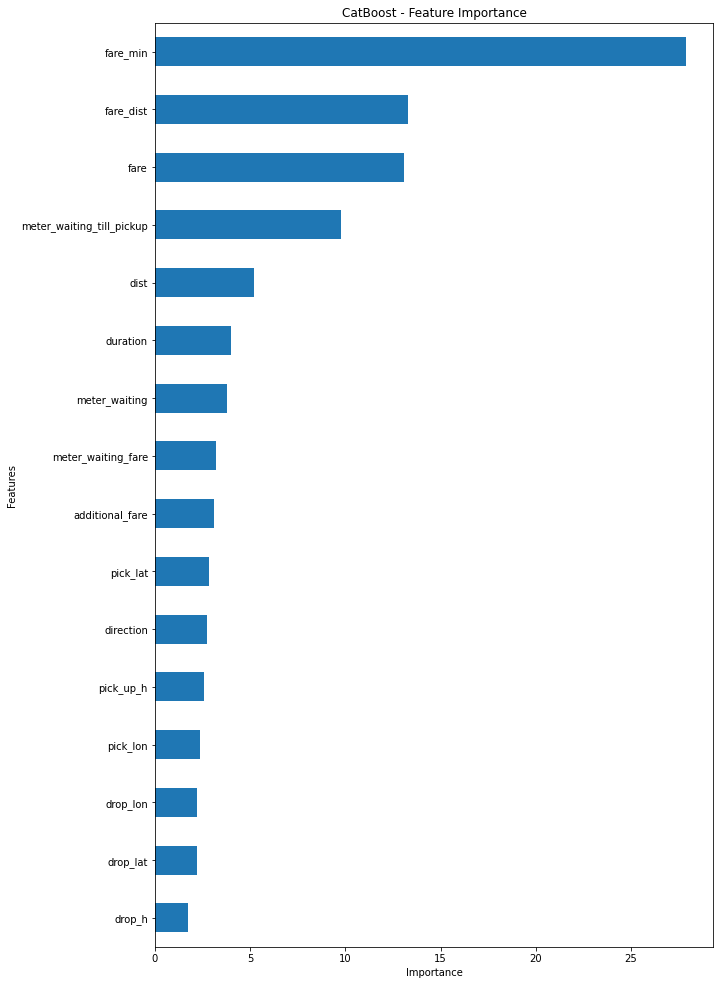

In [790]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fea_imp = pd.DataFrame({'imp': cat.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False])
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 17), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [791]:
import math
import numpy as np
from sklearn.preprocessing import StandardScaler

dft = pd.read_csv('test.csv')


def deg_to_rad(dr):
    return (dr*math.pi)/180

dft['pick_up_h'] = [int(d.split(' ')[1].split(':')[0]) for d in dft['pickup_time']]
dft['drop_h'] = [int(d.split(' ')[1].split(':')[0]) for d in dft['drop_time']]

#dft['day'] = [d.split(' ')[0] for d in dft['pickup_time']]
#dft['month'] = [int(d.split('/')[0]) for d in dft['day']]
#dft['day'] = [int(d.split('/')[1]) for d in dft['day']]
#dft['day_of_week'] = [d.split(' ')[0] for d in dft['pickup_time']]
#dft['day_of_week'] = pd.to_datetime(dft['day_of_week'])
#dft['day_of_week'] = dft['day_of_week'].dt.weekday_name
#dft['day_of_week'].value_counts()
#dft['day_of_week'] = dft['day_of_week'].map({'Monday': 1, 'Tuesday': 1,'Wednesday': 1, 'Thursday': 1,'Friday': 1, 'Saturday': 2,'Sunday': 2})

dft = dft.drop(['pickup_time','drop_time'], axis = 1)

dft['delta_lon'] = dft['pick_lon'] - dft['drop_lon']
dft['delta_lat'] = dft['pick_lat'] - dft['drop_lat']

dft['pick_lat'] = deg_to_rad(dft['pick_lat'])
dft['pick_lon'] = deg_to_rad(dft['pick_lon'])
dft['drop_lat'] = deg_to_rad(dft['drop_lat'])
dft['drop_lon'] = deg_to_rad(dft['drop_lon'])
dlon = dft['drop_lon'] - dft['pick_lon']
dlat = dft['drop_lat'] - dft['pick_lat']
dft['dist'] = np.sin(dlat/2)**2 + np.cos(dft['pick_lat'])*np.cos(dft['drop_lat'])*np.sin(dlon/2)**2
dft['dist'] = 2*np.arctan2(dft['dist']**0.5,(1-dft['dist'])**0.5)
R = 6373.0
dft['dist'] = R*dft['dist']
dft['dist'] = ((dft['pick_lat']-dft['drop_lat'])**2 + (dft['pick_lon']-dft['drop_lon'])**2)**0.5

dft['fare_min'] = (dft['fare'] / abs(dft['duration'] + 1 - dft['meter_waiting']))*60
dft['dist'] = df_test_dist['distance']
dft['fare_dist'] = (dft['fare'] / abs(dft['dist']))
#dft['waiting_min'] = dft['fare'] / abs(dft['meter_waiting']+ 1)
#dft['duration_move'] = abs(dft['duration'] - dft['meter_waiting']+ dft['meter_waiting_till_pickup']) #dont change minus
#dft['waiting'] = dft['meter_waiting']+ dft['meter_waiting_till_pickup']
#dft['fare_dist'] = dft['fare'] / abs(dft['dist']+1)
#dft['speed'] = dft['dist']/(dft['duration']+1)
dft.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pick_up_h,drop_h,delta_lon,delta_lat,dist,fare_min,fare_dist
0,213284604,10.5,924,42,2.4486,148,0.119285,1.394082,0.118244,1.394239,289.27,0,0,-0.0090,0.05964,8.283,19.655946,34.923337
1,213286352,10.5,4249,20,0.0000,91,0.120632,1.394035,0.114335,1.395750,1912.70,1,2,-0.0983,0.36077,56.384,27.130496,33.922744
2,213293973,10.5,1552,255,2.6588,23,0.120802,1.393607,0.120522,1.394499,394.00,5,5,-0.0511,0.01606,7.760,18.212635,50.773196
3,213294622,10.5,462,16,0.0000,198,0.118234,1.395244,0.118752,1.395228,154.32,5,5,0.0009,-0.02968,5.015,20.714094,30.771685
4,213298687,10.5,814,392,12.3692,69,0.121818,1.394745,0.121977,1.394368,147.47,7,7,0.0216,-0.00907,3.046,20.917730,48.414314


In [792]:

dft['direction'] = calculate_direction(dft['delta_lon'], dft['delta_lat'])

dft = dft.drop(['tripid','delta_lon','delta_lat'], axis = 1) 
X1 = dft

In [793]:
X

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pick_up_h,drop_h,dist,fare_min,fare_dist,direction
0,10.5,834.0,56.0,0.0000,64.0,0.119774,1.394506,0.120485,1.394139,270.32,0,0,7.801,20.820539,34.651968,-62.753420
1,10.5,791.0,47.0,0.0000,134.0,0.120181,1.394490,0.120667,1.394384,197.85,0,1,5.211,15.934228,37.967761,-77.641274
2,10.5,1087.0,80.0,0.0000,61.0,0.120574,1.393909,0.121068,1.394773,301.64,1,1,9.637,17.954762,31.300197,-150.242655
3,10.5,598.0,271.0,15.6638,68.0,0.120876,1.394335,0.120907,1.394467,82.30,2,2,1.880,15.054878,43.776596,-166.818323
5,10.5,3407.0,182.0,0.0000,112.0,0.124512,1.394464,0.120753,1.393905,1065.02,5,6,31.163,19.808184,34.175785,81.548736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17171,10.5,838.0,93.0,5.4219,451.0,0.127247,1.407376,0.127215,1.407708,198.26,22,22,3.943,15.945845,50.281512,174.528362
17172,10.5,2151.0,428.0,0.0000,39.0,0.120527,1.393673,0.121316,1.395197,581.23,23,23,17.569,20.228422,33.082702,-152.626918
17173,10.5,263.0,9.0,0.0000,110.0,0.123780,1.394518,0.123942,1.394548,76.20,23,23,2.697,17.929412,28.253615,-100.413825
17174,10.5,858.0,115.0,0.0000,317.0,0.121220,1.394113,0.121051,1.394536,133.31,23,23,3.398,10.750806,39.231901,158.239423


In [794]:
#X1 = dummy_df(X1, L)

In [795]:
X1

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pick_up_h,drop_h,dist,fare_min,fare_dist,direction
0,10.5,924,42,2.44860,148,0.119285,1.394082,0.118244,1.394239,289.27,0,0,8.283,19.655946,34.923337,98.581495
1,10.5,4249,20,0.00000,91,0.120632,1.394035,0.114335,1.395750,1912.70,1,2,56.384,27.130496,33.922744,105.241545
2,10.5,1552,255,2.65880,23,0.120802,1.393607,0.120522,1.394499,394.00,5,5,7.760,18.212635,50.773196,162.552812
3,10.5,462,16,0.00000,198,0.118234,1.395244,0.118752,1.395228,154.32,5,5,5.015,20.714094,30.771685,-88.263127
4,10.5,814,392,12.36920,69,0.121818,1.394745,0.121977,1.394368,147.47,7,7,3.046,20.917730,48.414314,-22.777896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8571,10.5,1723,429,24.83332,3,0.119573,1.395508,0.119658,1.394892,388.48,21,21,5.853,17.999073,66.372800,-7.823103
8572,10.5,1378,80,0.00000,125,0.120653,1.395663,0.120796,1.394483,379.85,21,22,10.815,17.545035,35.122515,-6.907937
8573,10.5,418,56,3.28440,93,0.119680,1.394659,0.119357,1.394663,112.79,22,22,2.300,18.642975,49.039130,90.619390
8574,10.5,1604,548,31.67440,17,0.120653,1.394249,0.120979,1.394771,248.46,22,22,6.213,14.103690,39.990343,-147.977395


In [796]:
yhat = cat.predict(X1)

In [797]:
df_test = pd.read_csv('test.csv')

In [798]:
df_test =df_test.drop(['meter_waiting_till_pickup','pickup_time','drop_time','pick_lat','pick_lon','drop_lat','drop_lon'], axis = 1) 

In [799]:
df_new = df_test

In [800]:
df_new = df_new.drop(['additional_fare','duration','meter_waiting','meter_waiting_fare','fare'], axis = 1) 

In [801]:
df_new['prediction'] = yhat


In [802]:
df_new

,tripid,prediction
0,213284604,1
1,213286352,1
2,213293973,1
3,213294622,1
4,213298687,1
...,...,...
8571,222856243,1
8572,222857785,1
8573,222858416,1
8574,222858691,1


In [803]:
df_new.head(10)

,tripid,prediction
0,213284604,1
1,213286352,1
2,213293973,1
3,213294622,1
4,213298687,1
5,213299545,0
6,213302332,1
7,213302671,1
8,213305594,1
9,213305134,1


In [804]:
df_new['prediction'].value_counts()

1    8145
0     431
Name: prediction, dtype: int64

In [806]:
df_new.to_csv("distance_updated_8145.csv",index=False)